In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

def showLabels(df_show):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_show, x='label')

def showIntLabels(df_show):
    labelLen = []
    labelLen.append(len(df_show.loc[df_show['label'] == 0]))
    for i in range(0,5):
        labelLen.append(len(df_show.loc[(df_show['label'] > i) & (df_show['label'] <= i+1)]))

    labels = ['0', '0.2 ~ 1.0', '1.2 ~ 2.0', '2.2 ~ 3.0', '3.2 ~ 4.0', '4.2 ~ 5.0']
    bar = plt.bar(labels, labelLen)
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2.0,height, height, ha = 'center', va='bottom', size=10)
    
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

df_train = pd.read_csv('../data/train.csv')
df_dev = pd.read_csv('../data/dev.csv')

df = pd.concat([df_train, df_dev])

# showLabels(df)

0it [00:00, ?it/s]


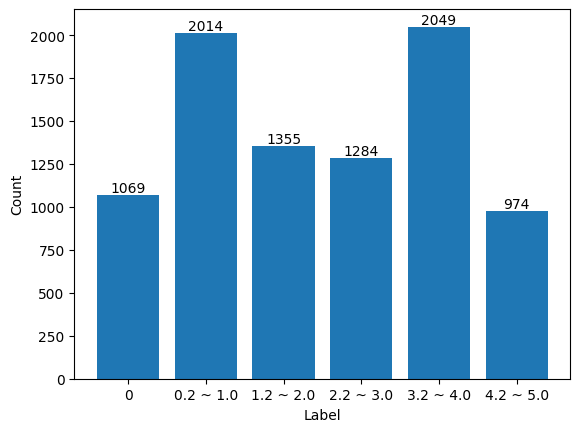

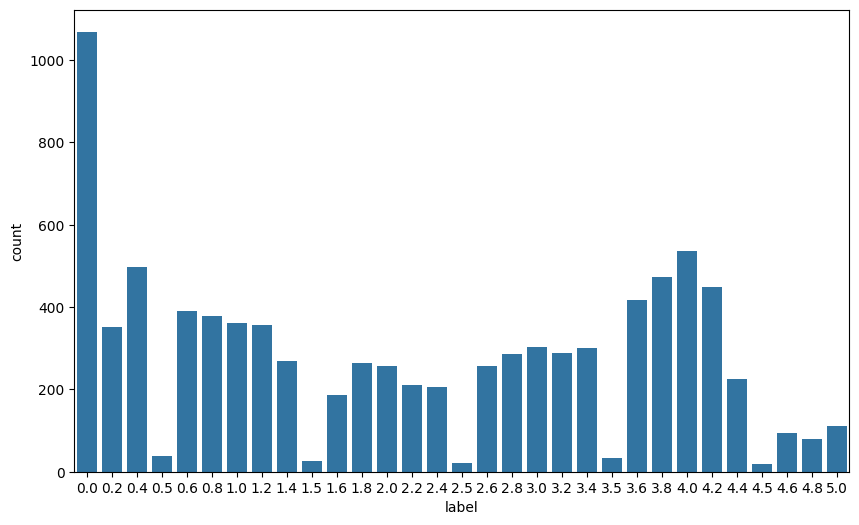

In [4]:
import re

from tqdm import tqdm, tqdm_pandas

from hanspell import spell_checker
from soynlp.normalizer import emoticon_normalize, repeat_normalize

tqdm_pandas(tqdm())

def safe_spell_checker(text):
    try:
        return spell_checker.check(text).checked
    except:
        return text

def preproecssing_text(text):
    # 특수기호 앞 글자가 삭제됨 ex) 노래ㅎㅎㅎ -> 노ㅎㅎㅎ
    # text = emoticon_normalize(text, num_repeats=2)
    text = repeat_normalize(text, num_repeats=2)
    text = text.lower()
    text = re.sub(r'[^a-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ?!<>\"\']', '', text)
    text.strip()
    text = safe_spell_checker(text)
    return text

df_tmp = df.copy()
df_tmp['sentence_1'] = df_tmp['sentence_1'].apply(preproecssing_text)
df_tmp['sentence_2'] = df_tmp['sentence_2'].apply(preproecssing_text)

df_label0 = df_tmp.loc[df_tmp['label'] == 0].sample(frac=0.5, random_state=42)
df_tmp.drop(df_label0.index, inplace=True)

showIntLabels(df_tmp)
showLabels(df_tmp)

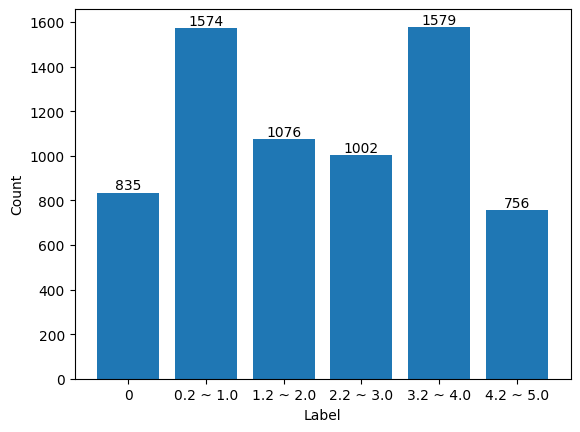

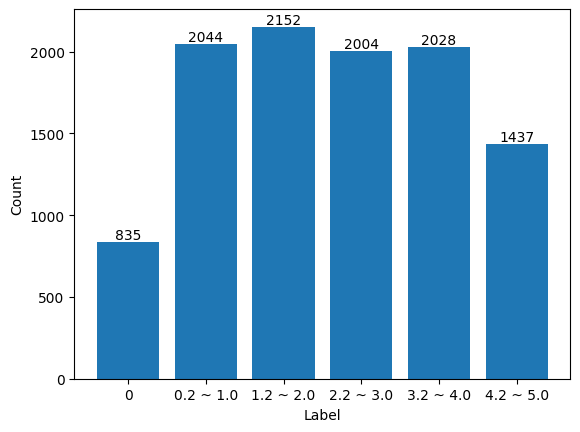

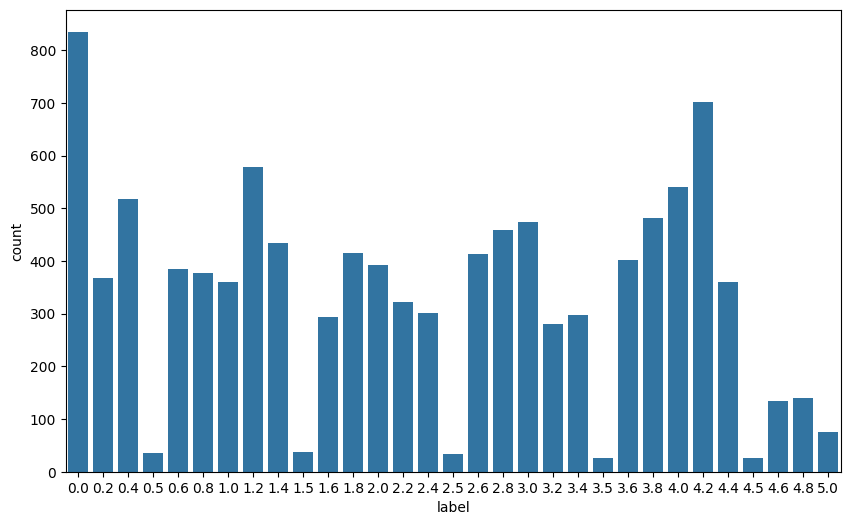

In [5]:
df_val = df_tmp.sample(frac=0.2, random_state=42)
df_train = df_tmp.drop(df_val.index)

showIntLabels(df_train)

df_tmp12 = df_train.loc[df_train['label'] > 1].copy()
df_tmp12 = df_tmp12.loc[df_tmp12['label'] <= 3]

df_tmp03 = df_train.loc[df_train['label'] > 0]
df_tmp03 = df_tmp03.loc[df_tmp03['label'] <= 4] 
df_tmp03.drop(df_tmp12.index, inplace=True)
df_tmp03 = df_tmp03.sample(frac=0.3, random_state=42)

df_tmp4 = df_train.loc[df_train['label'] > 4]
df_tmp4 = df_tmp4.loc[df_tmp4['label'] < 5]

df_tmp = pd.concat([df_tmp12, df_tmp03, df_tmp4])
df_tmp['sentence_1'], df_tmp['sentence_2'] = df_tmp['sentence_2'], df_tmp['sentence_1']

df_train = pd.concat([df_train, df_tmp])

showIntLabels(df_train)
showLabels(df_train)

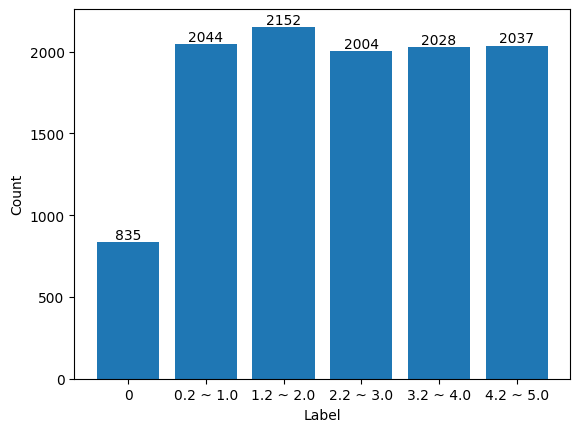

In [6]:
df_tmp = df_label0.sample(n=600, random_state=42)
df_tmp['sentence_2'] = df_tmp['sentence_1']
df_tmp['label'] = 5.0

df_train = pd.concat([df_train, df_tmp])

showIntLabels(df_train)

In [7]:
def reduce_repeated_hanguels(text, chars='ㅎㅋㅇㄷㅠㅜ', num_repeat=0):
    escaped_chars = re.escape(chars)
    pattern = f'([{escaped_chars}])\\1{{{num_repeat},}}'
    return re.sub(pattern, lambda m: m.group(1) * num_repeat, text)

def reduce_repeated_chars(text, chars='!<>.,', hangeuls='ㅎㅋㅇㄷㅠㅜ', num_repeat=1):
    escaped_chars = re.escape(chars)
    pattern = f'([{escaped_chars}])\\1{{{num_repeat},}}'
    return re.sub(pattern, lambda m: m.group(1) * num_repeat, text)

df_train['sentence_1'] = df_train['sentence_1'].apply(reduce_repeated_hanguels)
df_train['sentence_2'] = df_train['sentence_2'].apply(reduce_repeated_hanguels)
df_train['sentence_1'] = df_train['sentence_1'].apply(reduce_repeated_chars)
df_train['sentence_2'] = df_train['sentence_2'].apply(reduce_repeated_chars)

In [8]:
df_test = pd.read_csv('../data/test.csv')
df_test['sentence_1'] = df_test['sentence_1'].apply(preproecssing_text)
df_test['sentence_2'] = df_test['sentence_2'].apply(preproecssing_text)
df_test['sentence_1'] = df_test['sentence_1'].apply(reduce_repeated_hanguels)
df_test['sentence_2'] = df_test['sentence_2'].apply(reduce_repeated_hanguels)
df_test['sentence_1'] = df_test['sentence_1'].apply(reduce_repeated_chars)
df_test['sentence_2'] = df_test['sentence_2'].apply(reduce_repeated_chars)

df_train.to_csv('../data/train_preprocessed.csv', index=False)
df_val.to_csv('../data/val_preprocessed.csv', index=False)
df_test.to_csv('../data/test_preprocessed.csv', index=False)